In [9]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
import pandas as pd
from transformers import ViTModel
from transformers import BertTokenizer, BertModel
from sklearn.model_selection import train_test_split
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# -----------------------
# Cross-Attention Block
# -----------------------
class CrossAttentionBlock(nn.Module):
    def __init__(self, dim_q, dim_k, num_heads=8):
        super().__init__()
        self.attn = nn.MultiheadAttention(embed_dim=dim_q, num_heads=num_heads, batch_first=True)
        self.norm_q = nn.LayerNorm(dim_q)
        self.norm_k = nn.LayerNorm(dim_k)

    def forward(self, q, k, v, key_padding_mask=None):
        q_norm, k_norm = self.norm_q(q), self.norm_k(k)
        attn_out, attn_weights = self.attn(q_norm, k_norm, v, key_padding_mask=key_padding_mask)
        return q + attn_out, attn_weights


class AttentionPool(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.proj = nn.Linear(hidden_dim, 1)

    def forward(self, x):
        """
        x: (batch, seq_len, hidden_dim)
        returns: pooled (batch, hidden_dim)
        """
        weights = self.proj(x).squeeze(-1)  # (batch, seq_len)
        weights = F.softmax(weights, dim=-1)  # attention over sequence
        pooled = torch.bmm(weights.unsqueeze(1), x).squeeze(1)  # (batch, hidden_dim)
        return pooled
    
# -----------------------
# Symmetric Multimodal Classifier
# -----------------------
class SymmetricMultimodalClassifier(nn.Module):
    def __init__(self, text_model='bert-base-uncased', image_model='google/vit-base-patch16-224',
                 hidden_dim=768, num_classes=2):
        super().__init__()
        self.text_encoder = BertModel.from_pretrained(text_model)
        self.image_encoder = ViTModel.from_pretrained(image_model)

        self.text_to_img = CrossAttentionBlock(hidden_dim, hidden_dim)
        self.img_to_text = CrossAttentionBlock(hidden_dim, hidden_dim)

        self.text_pool = AttentionPool(hidden_dim)
        self.img_pool  = AttentionPool(hidden_dim)

        self.text_proj = nn.Linear(hidden_dim, hidden_dim)
        self.img_proj = nn.Linear(hidden_dim, hidden_dim)

        self.classifier = nn.Linear(hidden_dim, num_classes)

    def forward(self, input_ids, attention_mask, images):
        # Encode
        text_feat = self.text_encoder(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state
        img_feat = self.image_encoder(pixel_values=images).last_hidden_state

        # --- Symmetric Cross-Attention ---
        text_key_padding = (input_ids == tokenizer.pad_token_id)  # True for PAD

        # text -> image cross-attention
        text_cross, attn_t2i = self.text_to_img(text_feat, img_feat, img_feat)  # no mask needed for image
        # image -> text cross-attention
        img_cross, attn_i2t = self.img_to_text(img_feat, text_cross, text_cross,
                                            key_padding_mask=text_key_padding)

        # --- Mean pooling ---
        # text_emb = text_cross.mean(dim=1)
        # img_emb = img_cross.mean(dim=1)

        text_emb = self.text_pool(text_cross)
        img_emb = self.img_pool(img_cross)
        
        # --- Normalized embeddings for contrastive learning ---
        text_emb_n = F.normalize(self.text_proj(text_emb), dim=-1)
        img_emb_n = F.normalize(self.img_proj(img_emb), dim=-1)

        # --- Classification logits (use cross-attended text embedding) ---
        logits = self.classifier(text_emb)

        return logits, text_emb_n, img_emb_n, attn_t2i, attn_i2t

# -----------------------
# Symmetric InfoNCE Contrastive Loss
# -----------------------
def contrastive_loss(text_emb, img_emb, temperature=0.05):
    sim_matrix = torch.matmul(text_emb, img_emb.T) / temperature
    labels = torch.arange(sim_matrix.size(0), device=sim_matrix.device)
    loss_i = F.cross_entropy(sim_matrix, labels)
    loss_t = F.cross_entropy(sim_matrix.T, labels)
    return (loss_i + loss_t) / 2

In [16]:
class MultimodalNewsDataset(Dataset):
    def __init__(self, txt_file, image_dir, tokenizer, max_len=128, transform=None):
        self.data = pd.read_csv(txt_file, sep='\t')
        self.image_dir = image_dir
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.transform = transform
        
    def __len__(self):
        return len(self.data)
    
    def get_img_id(self, idx):
        row = self.data.iloc[idx]
        img_id = str(row['id'])
        return img_id
    
    def __getitem__(self, idx):
        row = self.data.iloc[idx]
        text = str(row['clean_title'])
        img_id = str(row['id'])
        label = torch.tensor(int(row['2_way_label']), dtype=torch.long)
        
        img_path = os.path.join(self.image_dir, f"{img_id}.jpg")
        
        try:
            image = Image.open(img_path).convert("RGB")
        except Exception as e:
            # print(f"[WARN] Ошибка при открытии {img_path}: {e}")
            # Возвращаем пустое изображение, чтобы не ломать batch
            image = Image.new("RGB", (224, 224), (0, 0, 0))
        if self.transform:
            image = self.transform(image)
        else:
            image = transforms.ToTensor()(image)
        
        encoding = self.tokenizer(
            text,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_tensors='pt'
        )
        input_ids = encoding['input_ids'].squeeze(0)
        attention_mask = encoding['attention_mask'].squeeze(0)
        
        return input_ids, attention_mask, image, label


In [17]:
tokenizer = BertTokenizer.from_pretrained("checkpoints/tokenizer")

dataset_path = '/repo/project_deepfake/project/fakeddit_dataset'
transform_train = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

transform_val = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset = MultimodalNewsDataset(
    txt_file=dataset_path+'/text/text.txt',
    image_dir=dataset_path+'/images',
    tokenizer=tokenizer,
    transform=transform_train 
)

# Split indices
train_idx, val_idx = train_test_split(
    range(len(dataset)),
    test_size=0.2,
    random_state=42,
    stratify=dataset.data['2_way_label']
)

train_set = Subset(dataset, train_idx)
val_set   = Subset(dataset, val_idx)

val_set.dataset.transform = transform_val  

train_loader = DataLoader(train_set, batch_size=8, shuffle=True)
val_loader = DataLoader(val_set, batch_size=8, shuffle=False)

In [ ]:
val_set.dataset.get_img_id(0)

'cozywbv'

In [5]:
model = torch.load("checkpoints/multimodal_model.pth", map_location=device)
model = model.to(device)

In [19]:
import torch
import numpy as np
from tqdm import tqdm
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score, precision_score, recall_score, confusion_matrix

def evaluate_model_full(model, dataloader, device='cuda'):
    """
    Evaluate model on dataloader and return probabilities and standard metrics.
    Metrics: Accuracy, AUC, F1, Precision, Recall, Confusion Matrix
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    all_probs = []
    all_labels = []

    with torch.no_grad():
        for batch in tqdm(dataloader, desc="Evaluating"):
            input_ids, attention_mask, images, labels = batch

            input_ids = input_ids.to(device)
            attention_mask = attention_mask.to(device)
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            output = model(input_ids, attention_mask, images)
            logits = output[0] if isinstance(output, tuple) else output  # (B,2)

            # Probabilities for class 1
            probs = torch.softmax(logits, dim=1)[:, 1]

            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_probs = np.array(all_probs)
    all_labels = np.array(all_labels)

    # Binary predictions at threshold 0.5
    preds = (all_probs >= 0.2609).astype(int)

    # Metrics
    acc = accuracy_score(all_labels, preds)
    auc = roc_auc_score(all_labels, all_probs)
    f1 = f1_score(all_labels, preds)
    precision = precision_score(all_labels, preds)
    recall = recall_score(all_labels, preds)
    cm = confusion_matrix(all_labels, preds)

    # Print results
    print(f"Accuracy:  {acc:.4f}")
    print(f"AUC:       {auc:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print("Confusion Matrix:")
    print(cm)

    return all_probs, all_labels, preds, cm


In [20]:
probs, labels, preds, cm = evaluate_model_full(model, val_loader, device=device)

print("Probabilities:", probs[:10])
print("Predictions:  ", preds[:10])


Evaluating:   0%|          | 0/1416 [00:00<?, ?it/s]/root/miniconda/lib/python3.12/site-packages/torch/nn/modules/conv.py:456: UserWarning: Applied workaround for CuDNN issue, install nvrtc.so (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:84.)
  return F.conv2d(input, weight, bias, self.stride,
Evaluating:   8%|▊         | 120/1416 [00:08<01:29, 14.46it/s]/root/miniconda/lib/python3.12/site-packages/PIL/Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
Evaluating:  68%|██████▊   | 957/1416 [01:06<00:34, 13.18it/s]/root/miniconda/lib/python3.12/site-packages/PIL/Image.py:3186: DecompressionBombWarning: Image size (127383200 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
Evaluating: 100%|██████████| 1416/1416 [01:38<00:00, 14.31it/s]

Accuracy:  0.8508
AUC:       0.9267
F1 Score:  0.8206
Precision: 0.7706
Recall:    0.8775
Confusion Matrix:
[[5770 1150]
 [ 539 3862]]
Probabilities: [6.8688305e-06 9.9162138e-01 5.0681305e-01 1.2936733e-04 9.7515327e-01
 1.1445555e-04 2.8745513e-03 2.3317389e-04 2.6003996e-02 5.3004426e-04]
Predictions:   [0 1 1 0 1 0 0 0 0 0]


In [21]:
img_ids = []

for idx in range(len(probs)):
    img_id = dataset.get_img_id(idx)
    img_ids.append(img_id)
df = pd.DataFrame({
    'id': img_ids,
    'label': probs
})

df.to_csv('predictions.csv', index=False, sep='\t') 

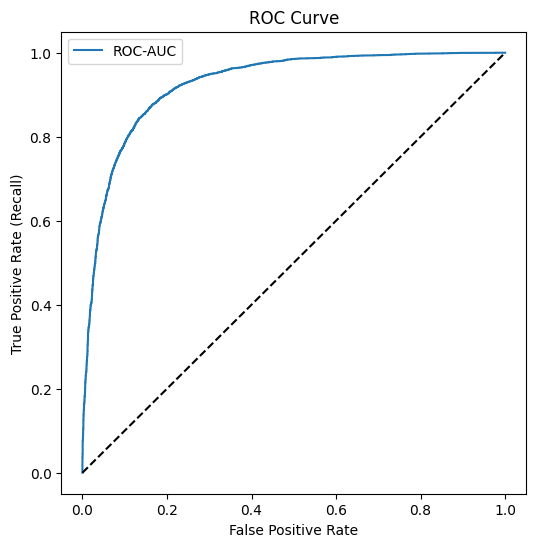

Best threshold (Youden's J): 0.260966


In [175]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(labels, probs)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC-AUC")
plt.plot([0,1], [0,1], 'k--')  # random line
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.show()

J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print("Best threshold (Youden's J):", best_thresh)


In [158]:
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import cv2
from torchvision import transforms
from PIL import Image

# -----------------------
# Utilities
# -----------------------
def normalize01(x):
    x = x - x.min()
    if x.max() != 0:
        x = x / x.max()
    return x

def pil_from_tensor(tensor):
    return transforms.ToPILImage()(tensor.cpu().clamp(0,1))

# -----------------------
# Grad-CAM generator for ViT (by gradients on ViT patch embeddings)
# -----------------------
def generate_vit_gradcam(model, input_ids, attention_mask, image_tensor, target_class=None, device='cuda'):
    """
    возвращает: cam_map (H,W normalized 0..1), predicted_class, confidence, attn_t2i, attn_i2t
    input_ids, attention_mask: 1D tensors (for single sample)
    image_tensor: 3xHxW tensor (single sample)
    """
    model.eval()
    device = torch.device(device if torch.cuda.is_available() else "cpu")

    # move inputs
    input_ids = input_ids.unsqueeze(0).to(device)          # (1, L)
    attention_mask = attention_mask.unsqueeze(0).to(device)
    image_tensor = image_tensor.unsqueeze(0).to(device)    # (1,3,H,W)

    # --- 1) get text features (no grad needed unless you want grads w.r.t text) ---
    with torch.no_grad():
        text_outputs = model.text_encoder(input_ids=input_ids, attention_mask=attention_mask)
        text_feats = text_outputs.last_hidden_state   # (1, L, D)

    # --- 2) get image features but keep gradients on them ---
    vit_outputs = model.image_encoder(pixel_values=image_tensor)
    img_feats = vit_outputs.last_hidden_state   # (1, P+1, D)
    # make img_feats require grad so gradients flow here
    img_feats = img_feats.detach()
    img_feats.requires_grad_(True)

    # --- 3) run symmetric cross-attention manually using model blocks ---
    # text_to_img: q=text, k=v=img
    # img_to_text: q=img, k=v=text
    # We expect these blocks to return (out, attn_weights)
    text_cross, attn_t2i = model.text_to_img(text_feats, img_feats, img_feats)
    img_cross,  attn_i2t = model.img_to_text(img_feats, text_cross, text_cross, key_padding_mask=(attention_mask==0))  # note: feed updated text_cross for consistency

    # --- 4) pool cross-attended representations ---
    # per your request — use only cross-attended outputs (mean pooling)
    text_emb = text_cross.mean(dim=1)   # (1, D)
    img_emb  = img_cross.mean(dim=1)    # (1, D)

    # --- 5) classification logits (use cross-attended text_emb per design) ---
    logits = model.classifier(text_emb)   # (1, num_classes)
    probs = F.softmax(logits, dim=1)
    pred_class = int(probs.argmax(dim=1).item())
    confidence = float(probs[0, pred_class].item())
    if target_class is None:
        target_class = pred_class

    # --- 6) contrastive projections exist in model but not needed here
    # compute score and backward to get gradients w.r.t img_feats
    score = logits[0, target_class]
    model.zero_grad()
    score.backward(retain_graph=True)

    # --- 7) obtain gradients on img_feats ---
    if img_feats.grad is None:
        # fallback: try to get gradient from img_cross if not propagated to img_feats
        grads = img_cross.grad
    else:
        grads = img_feats.grad    # (1, P+1, D)

    if grads is None:
        raise RuntimeError("Gradients on image features are None — ensure computation graph connects logits to img_feats.")

    # --- 8) compute patch importance: global-average over feature dim D -->
    # grads: (1, P+1, D)  -> avg over D -> (1, P+1)
    weights = grads.mean(dim=-1).squeeze(0).detach().cpu().numpy()   # (P+1,)

    # ignore CLS token (index 0)
    patch_weights = weights[1:]   # (P,)
    patch_weights = np.maximum(patch_weights, 0)
    patch_weights = normalize01(patch_weights)

    # --- 9) reshape to grid ---
    # determine grid size from number of patches
    P = patch_weights.shape[0]
    grid_size = int(np.sqrt(P))
    if grid_size * grid_size != P:
        # try to infer from vit config if available
        try:
            img_size = model.image_encoder.config.image_size
            patch_size = model.image_encoder.config.patch_size
            grid_size = img_size // patch_size
        except Exception:
            raise ValueError(f"Cannot infer grid size for P={P}")
    cam_map = patch_weights.reshape(grid_size, grid_size)   # (g,g)
    # upscale to image size (assume image_tensor size)
    H = image_tensor.shape[-2]
    W = image_tensor.shape[-1]
    cam_up = cv2.resize(cam_map, (W, H))
    cam_up = normalize01(cam_up)

    return cam_up, pred_class, confidence, attn_t2i, attn_i2t, text_feats, img_feats.detach()

# -----------------------
# Attention overlay from text->image: map token -> per-patch scores
# -----------------------
def attention_patch_scores(attn_t2i, token_index=0):
    """
    attn_t2i may be:
      - tensor shape (1, heads, tgt_len_text, src_len_patches)  OR
      - tensor shape (1, tgt_len_text, src_len_patches)
      - or list/tuple per layer (handle common cases)
    We aggregate to get per-patch scores for a chosen token_index.
    Returns normalized per-patch vector length P.
    """
    # convert to tensor and squeeze batch
    if isinstance(attn_t2i, list) or isinstance(attn_t2i, tuple):
        # if list per layer, stack and mean
        attn = torch.stack([a for a in attn_t2i], dim=0)   # (L, B, ...)
    else:
        attn = attn_t2i

    attn = torch.as_tensor(attn)
    attn = attn.squeeze(0)   # drop batch -> shape may be (heads, T, P) or (T, P)
    if attn.ndim == 3:
        # (heads, T, P) -> mean over heads -> (T,P)
        attn2 = attn.mean(dim=0)
    elif attn.ndim == 2:
        attn2 = attn
    else:
        raise ValueError(f"Unexpected attn shape after squeeze: {attn.shape}")

    # attn2: (T, P)
    if token_index is None:
        # aggregate over tokens
        patch_scores = attn2.mean(dim=0).detach().cpu().numpy()
    else:
        patch_scores = attn2[token_index].detach().cpu().numpy()

    patch_scores = np.maximum(patch_scores, 0)
    patch_scores = normalize01(patch_scores)
    return patch_scores  # (P,)

# -----------------------
# Visualization: combine Grad-CAM and attention overlay, show top tokens
# -----------------------
def visualize_multimodal_explanation(model, tokenizer, sample, device='cuda',
                                     top_k_tokens=8, token_index=None, patch_size=16, img_size=224):
    """
    sample: (input_ids, attention_mask, image_tensor, label) from your Dataset
    token_index: if None -> show aggregated attention over tokens; else integer token index to visualize mapping
    """
    input_ids, attention_mask, image_tensor, label = sample
    # run generator
    cam_map, pred_class, conf, attn_t2i, attn_i2t, text_feats, img_feats = generate_vit_gradcam(
        model, input_ids, attention_mask, image_tensor, device=device
    )

    # attention patch scores (from text->image) for the token_index
    # if token_index is None => aggregate over tokens
    # tokenizer.convert_ids_to_tokens for readable tokens
    token_ids = input_ids.cpu().numpy()
    tokens = tokenizer.convert_ids_to_tokens(token_ids)

    # choose token_index: if None -> we'll find top tokens by aggregated attention image->text
    # compute image->text aggregated importance (which tokens receive more attention from patches)
    # attn_i2t shape handling similar to attn_t2i
    # aggregate attn_i2t to per-token importance:
    attn_i2t_tensor = attn_i2t
    if isinstance(attn_i2t_tensor, list) or isinstance(attn_i2t_tensor, tuple):
        attn_i2t_tensor = torch.stack(attn_i2t_tensor, dim=0)
    attn_i2t_tensor = torch.as_tensor(attn_i2t_tensor).squeeze(0)  # (heads, P, T) or (P,T)

    if attn_i2t_tensor.ndim == 3:
        attn_i2t_mean = attn_i2t_tensor.mean(dim=0)   # (P,T)
    else:
        attn_i2t_mean = attn_i2t_tensor  # (P,T)

    # per-token importance: average over patches
    token_importance = attn_i2t_mean.mean(dim=0).detach().cpu().numpy()  # (T,)

    # top tokens
    top_idx = np.argsort(token_importance)[-top_k_tokens:][::-1]
    print("Top tokens by image->text attention (token, score):")
    for idx in top_idx:
        tok = tokens[idx] if idx < len(tokens) else f"tok{idx}"
        print(f"  {idx:3d}: {tok:15s}  {token_importance[idx]:.4f}")

    # If token_index is None, we visualize aggregated attention map (mean over tokens)
    if token_index is None:
        # aggregated text->image attn: get patch scores aggregated over tokens
        patch_scores = attention_patch_scores(attn_t2i, token_index=None)  # (P,)
    else:
        patch_scores = attention_patch_scores(attn_t2i, token_index=token_index)  # (P,)

    # reshape to grid
    P = patch_scores.shape[0]
    patch_scores = patch_scores[1:]
    grid = int(np.sqrt(P))
    patch_map = patch_scores.reshape(grid, grid)
    patch_map_up = cv2.resize(patch_map, (img_size, img_size))
    patch_map_up = normalize01(patch_map_up)

    # combine cam_map and patch_map_up: show side-by-side and blended
    pil_img = pil_from_tensor(image_tensor)
    img_np = np.array(pil_img)

    # gradcam overlay
    heatmap_cam = cv2.applyColorMap(np.uint8(255 * cam_map), cv2.COLORMAP_JET)
    heatmap_cam = cv2.cvtColor(heatmap_cam, cv2.COLOR_BGR2RGB)
    overlay_cam = (0.6 * img_np + 0.4 * heatmap_cam).astype(np.uint8)

    # attention overlay
    heatmap_attn = cv2.applyColorMap(np.uint8(255 * patch_map_up), cv2.COLORMAP_JET)
    heatmap_attn = cv2.cvtColor(heatmap_attn, cv2.COLOR_BGR2RGB)
    overlay_attn = (0.6 * img_np + 0.4 * heatmap_attn).astype(np.uint8)

    # blended combination
    blended = (0.5 * overlay_cam.astype(float) + 0.5 * overlay_attn.astype(float)).astype(np.uint8)

    # Plot
    fig, axes = plt.subplots(1, 4, figsize=(18, 6))
    axes[0].imshow(img_np); axes[0].set_title("Original"); axes[0].axis('off')
    axes[1].imshow(overlay_cam); axes[1].set_title(f"Grad-CAM (pred {pred_class}, conf {conf:.2f})"); axes[1].axis('off')
    axes[2].imshow(overlay_attn); axes[2].set_title("Text->Image attention overlay"); axes[2].axis('off')
    axes[3].imshow(blended); axes[3].set_title("Blended CAM + Attention"); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

    # return maps if needed
    return {
        "cam_map": cam_map,
        "patch_map": patch_map_up,
        "pred_class": pred_class,
        "confidence": conf,
        "top_tokens": [(int(i), tokens[int(i)], float(token_importance[int(i)])) for i in top_idx]
    }


corndogs
Top tokens by image->text attention (token, score):
    3: ##s              0.4058
    0: [CLS]            0.2421
    1: corn             0.2255
    2: ##dog            0.1240
    4: [SEP]            0.0027
   41: [PAD]            0.0000
   46: [PAD]            0.0000
   45: [PAD]            0.0000


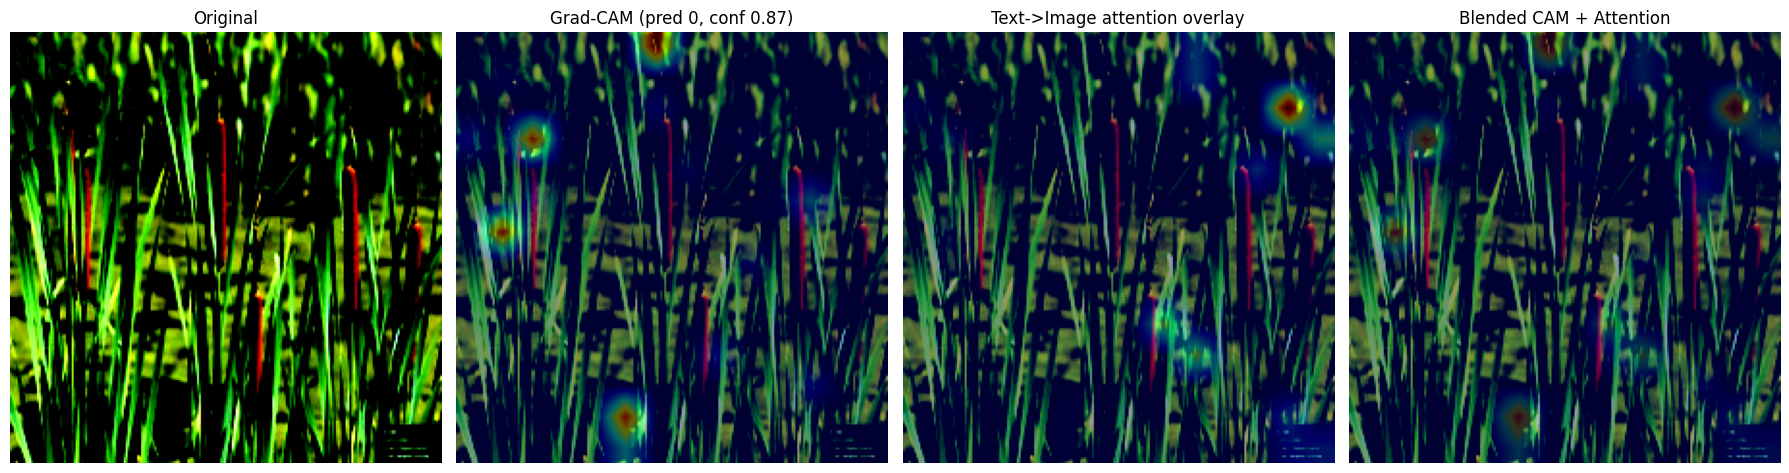

In [159]:
sample = val_set[30]  # (input_ids, attention_mask, image, label)
input_ids, attention_mask, image, label = sample
decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
print(decoded_text)

res = visualize_multimodal_explanation(model, tokenizer, sample, device=device, top_k_tokens=8, token_index=None)


=== Sample 2715 ===
Text: photo i took of a bird and plane almost in sync
Label: tensor(1)
Top tokens by image->text attention (token, score):
    7: and              0.3491
   11: sync             0.1937
    6: bird             0.1024
    3: took             0.1021
    9: almost           0.0822
    8: plane            0.0692
    5: a                0.0681
   10: in               0.0161


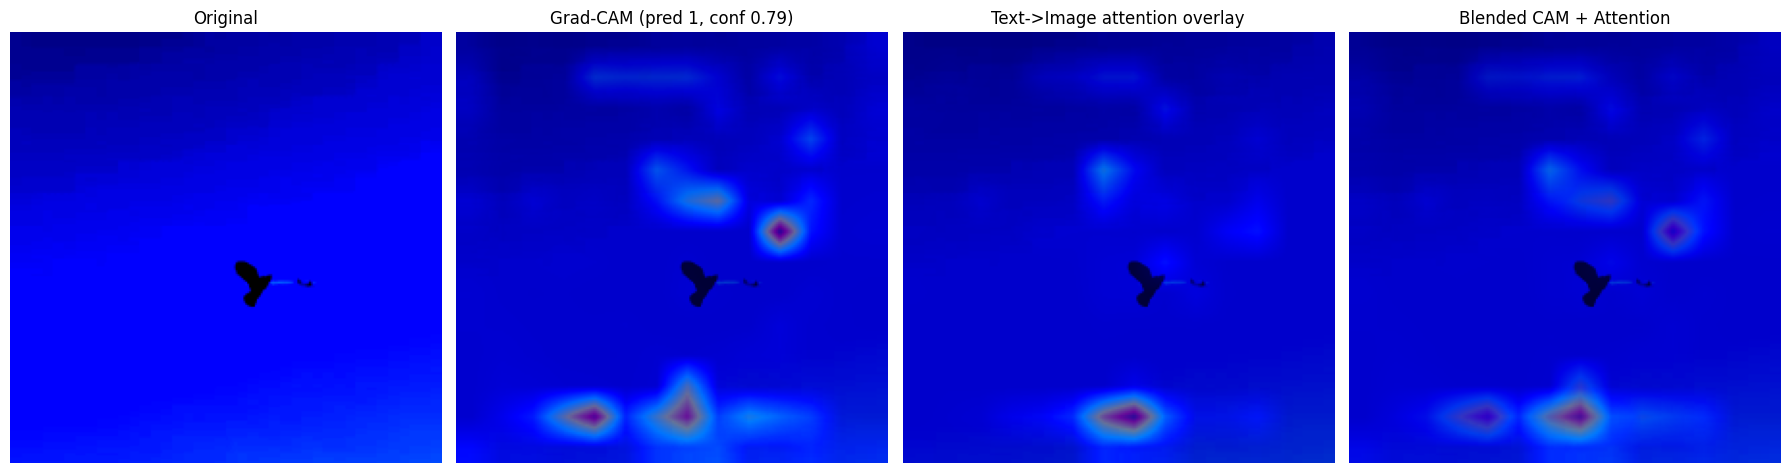


=== Sample 7573 ===
Text: daniel ricciardo celebrating by sticking his tongue out
Label: tensor(1)
Top tokens by image->text attention (token, score):
   10: out              0.3760
    5: celebrating      0.3638
    1: daniel           0.1329
    0: [CLS]            0.1251
    9: tongue           0.0021
    7: sticking         0.0000
    4: ##rdo            0.0000
   11: [SEP]            0.0000


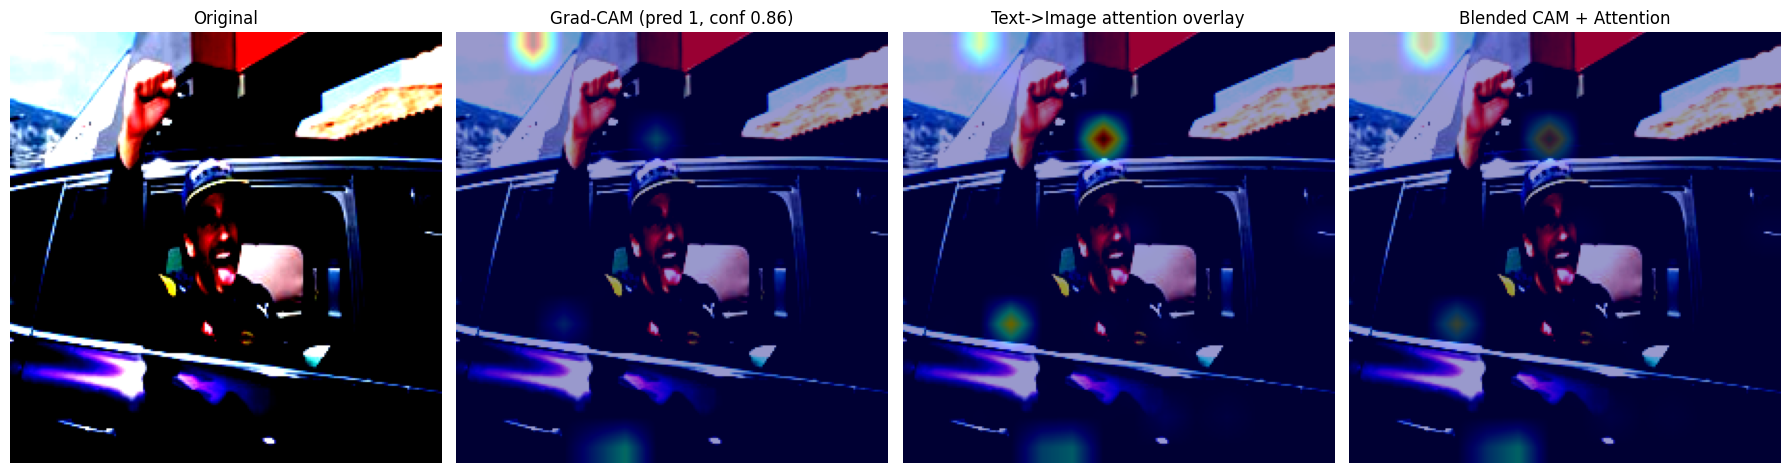


=== Sample 7669 ===
Text: philippines rodrigo duterte threatens to leave un
Label: tensor(1)
Top tokens by image->text attention (token, score):
    8: leave            0.3543
    6: threatens        0.2656
    9: un               0.1536
    4: ##ter            0.1143
    2: rodrigo          0.0842
    0: [CLS]            0.0150
    1: philippines      0.0082
    3: du               0.0041


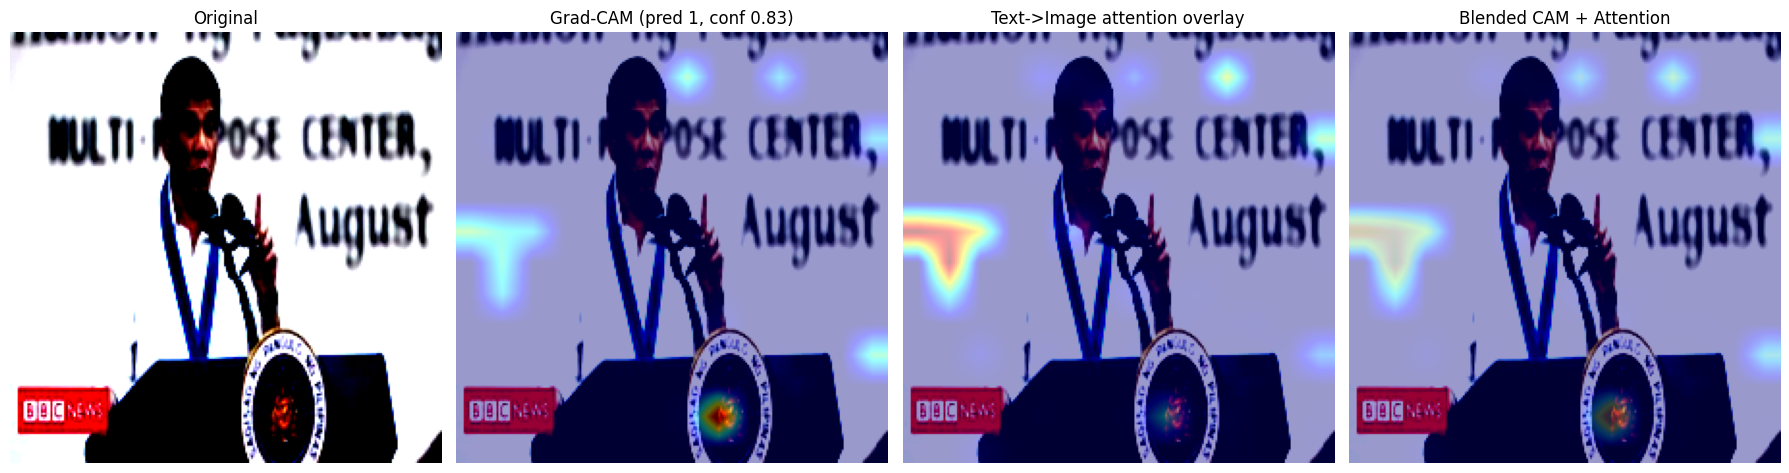


=== Sample 8199 ===
Text: if hillary won
Label: tensor(0)
Top tokens by image->text attention (token, score):
    1: if               0.6149
    0: [CLS]            0.2329
    3: won              0.1490
    4: [SEP]            0.0019
    2: hillary          0.0012
   41: [PAD]            0.0000
   46: [PAD]            0.0000
   45: [PAD]            0.0000


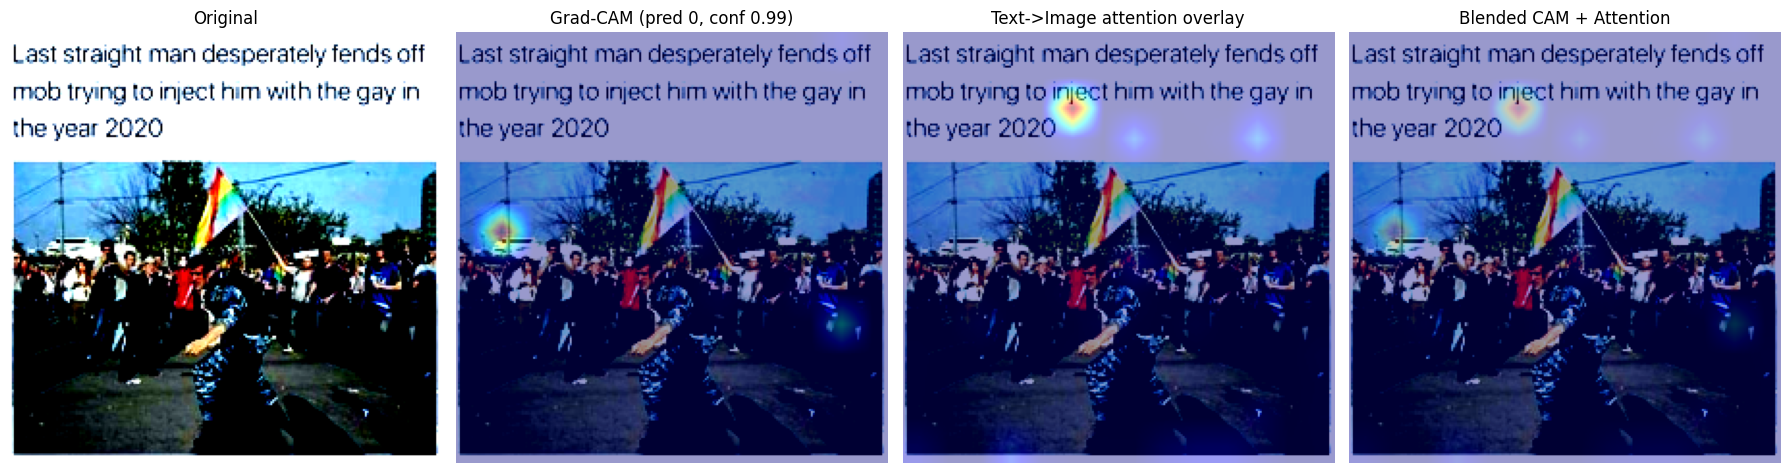


=== Sample 1062 ===
Text: adulf
Label: tensor(0)
Top tokens by image->text attention (token, score):
    2: ##ulf            0.3745
    1: ad               0.3224
    0: [CLS]            0.2808
    3: [SEP]            0.0223
   41: [PAD]            0.0000
   46: [PAD]            0.0000
   45: [PAD]            0.0000
   44: [PAD]            0.0000


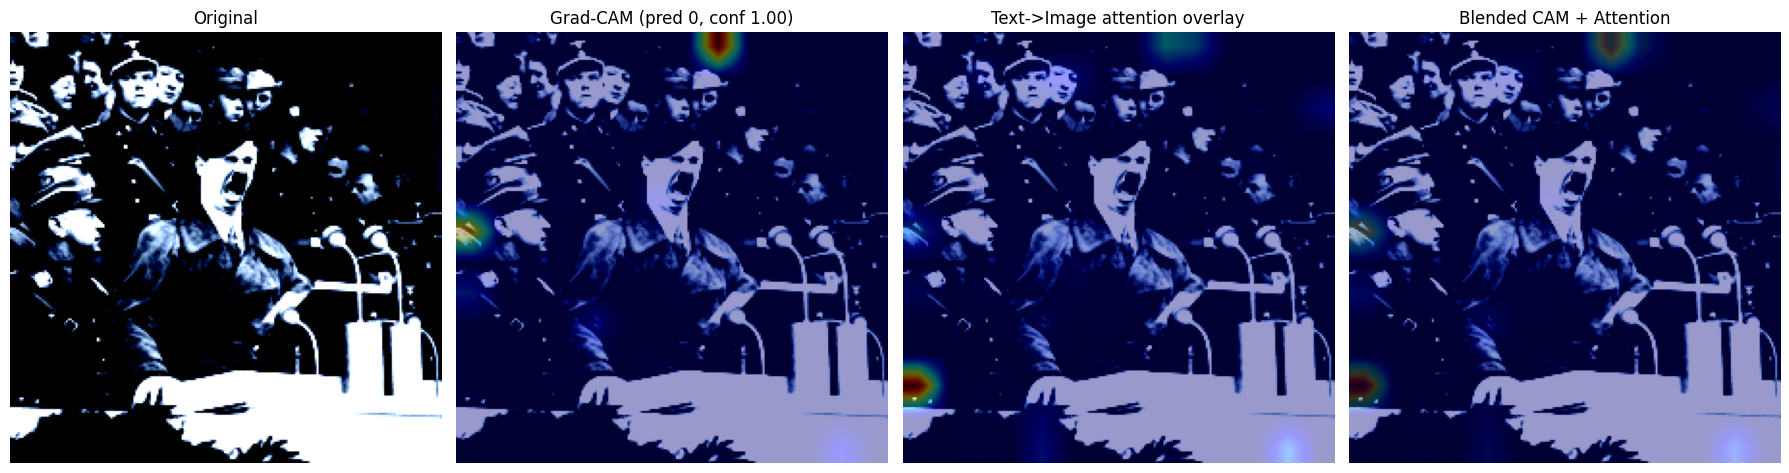

In [160]:
import random

# how many examples to visualize
num_samples = 5

# randomly choose indices from validation set
indices = random.sample(range(len(val_set)), num_samples)

for i in indices:
    print(f"\n=== Sample {i} ===")
    sample = val_set[i]
    input_ids, attention_mask, image, label = sample

    # print decoded text for context
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    print("Text:", decoded_text)
    print("Label:", label)

    # visualize and get results
    res = visualize_multimodal_explanation(
        model,
        tokenizer,
        sample,
        device=device,
        top_k_tokens=8,
        token_index=None
    )
